# Strompreis-Analyse & Prognose (Industrie, Destatis)

Dieses Notebook verarbeitet Strompreisdaten für nicht-haushaltliche Abnehmer (Industrie) von Destatis.
Es bereinigt und transformiert die Daten, führt Zeitreihenprognosen mit Facebook Prophet durch und visualisiert historische sowie zukünftige prognostizierte Entwicklungen bis 2050 (halbjährlich).

Hinweis: Die Prognosebereiche ab 2025 sind im Diagramm grau hinterlegt.  
Quelle: FIXME


In [161]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import xlsxwriter
import os

PREISE_INDUSTRIE = "in/prices/61243-0005_de_flat_strompreise_nichthaushalte.csv"

# Pfad, falls noch nicht gesetzt

PLOT_OUT_DIR = "out/price/destatis"
EXCEL_OUTPUT = f"out/price/destatis_electricity_prices.xlsx"

os.makedirs(PLOT_OUT_DIR, exist_ok=True)

In [155]:
df_industrie_raw = pd.read_csv(PREISE_INDUSTRIE, delimiter=';', encoding='utf-8')

relevante_preisarten = [
    "Durchschnittspreise ohne Steuern, Abgaben, Umlagen",
    "Durchschnittspreise ohne Umsatzsteuer u.a. abz.St.",
    "Durchschnittspreise inkl.Steuern, Abgaben, Umlagen"
]

df_industrie_cleaned = df_industrie_raw[[  
    "time",  # Jahr
    "1_variable_attribute_label",  # Halbjahr
    "2_variable_attribute_label",  # Gebiet (z. B. Deutschland)
    "3_variable_attribute_label",  # Preisart
    "4_variable_attribute_label",  # Verbrauchsklasse
    "value"  # Preiswert als String mit Komma
]]

# Spalten umbenennen
df_industrie_cleaned.columns = [
    "Jahr", "Halbjahr", "Gebiet", "Preisart", "Verbrauchsklasse", "Preis_EUR_kWh"
]

# Preiswert umwandeln: Komma → Punkt → Float
df_industrie_cleaned["Preis_EUR_kWh"] = df_industrie_cleaned["Preis_EUR_kWh"].str.replace(",", ".", regex=False)
df_industrie_cleaned["Preis_EUR_kWh"] = pd.to_numeric(df_industrie_cleaned["Preis_EUR_kWh"], errors="coerce")
df_industrie_cleaned = df_industrie_cleaned.dropna(subset=["Preis_EUR_kWh"])

# Nur relevante Preisarten behalten
df_industrie_cleaned = df_industrie_cleaned[df_industrie_cleaned["Preisart"].isin(relevante_preisarten)]

# In Wide-Format bringen
df_industrie_wide = df_industrie_cleaned.pivot_table(
    index=["Jahr", "Halbjahr", "Gebiet", "Verbrauchsklasse"],
    columns="Preisart",
    values="Preis_EUR_kWh"
).reset_index()

# Spaltennamen bereinigen und umbenennen
df_industrie_wide.columns.name = None
df_industrie_wide.rename(columns={
    "Durchschnittspreise ohne Steuern, Abgaben, Umlagen": "Netto_ohne_Abgaben",
    "Durchschnittspreise ohne Umsatzsteuer u.a. abz.St.": "Netto_ohne_USt",
    "Durchschnittspreise inkl.Steuern, Abgaben, Umlagen": "Brutto"
}, inplace=True)

df_industrie_wide

C:\Users\sulta\AppData\Local\Temp\ipykernel_11596\2905967537.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_industrie_cleaned["Preis_EUR_kWh"] = df_industrie_cleaned["Preis_EUR_kWh"].str.replace(",", ".", regex=False)
C:\Users\sulta\AppData\Local\Temp\ipykernel_11596\2905967537.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_industrie_cleaned["Preis_EUR_kWh"] = pd.to_numeric(df_industrie_cleaned["Preis_EUR_kWh"], errors="coerce")


,Jahr,Halbjahr,Gebiet,Verbrauchsklasse,Brutto,Netto_ohne_Abgaben,Netto_ohne_USt
0,2019,2. Halbjahr,Deutschland,150 000 MWh und mehr,0.1114,0.0348,0.0768
1,2019,2. Halbjahr,Deutschland,2 000 bis unter 20 000 MWh,0.1781,0.0623,0.1361
2,2019,2. Halbjahr,Deutschland,20 000 bis unter 70 000 MWh,0.1479,0.0513,0.1093
3,2019,2. Halbjahr,Deutschland,20 bis unter 500 MWh,0.2232,0.0872,0.1863
4,2019,2. Halbjahr,Deutschland,500 bis unter 2 000 MWh,0.1989,0.0718,0.1608
...,...,...,...,...,...,...,...
83,2024,2. Halbjahr,Deutschland,20 bis unter 500 MWh,0.3233,0.2302,0.2714
84,2024,2. Halbjahr,Deutschland,500 bis unter 2 000 MWh,0.2834,0.2010,0.2359
85,2024,2. Halbjahr,Deutschland,70 000 bis unter 150 000 MWh,0.1874,0.1313,0.1430
86,2024,2. Halbjahr,Deutschland,Insgesamt,0.2538,0.1800,0.2055


In [156]:
# Nur die Gesamtverbrauchsklasse beibehalten, halbjährlich
df_preise_industrie = (
    # df_industrie_wide[df_industrie_wide["Verbrauchsklasse"] == "Insgesamt"]
    df_industrie_wide[df_industrie_wide["Verbrauchsklasse"] == "20 000 bis unter 70 000 MWh"]
    .sort_values(["Jahr", "Halbjahr"])
    .reset_index(drop=True)
)

# Melt auf lange Form – Behalte Jahr & Halbjahr
df_preise_prophet = df_preise_industrie.melt(
    id_vars=["Jahr", "Halbjahr"],
    value_vars=["Brutto", "Netto_ohne_Abgaben", "Netto_ohne_USt"],
    var_name="Preisart",
    value_name="Preis_EUR_kWh"
)

# Halbjahr zu Monatszahl (1 = Januar, 7 = Juli)
halbjahr_to_month = {"1. Halbjahr": 1, "2. Halbjahr": 7}
df_preise_prophet["Monat"] = df_preise_prophet["Halbjahr"].map(halbjahr_to_month)

# Prophet-kompatibles Zeitformat ("ds") erstellen
df_preise_prophet["ds"] = pd.to_datetime(
    df_preise_prophet["Jahr"].astype(str) + "-" +
    df_preise_prophet["Monat"].astype(str).str.zfill(2) + "-01"
)

# Zielspalte umbenennen
df_preise_prophet.rename(columns={"Preis_EUR_kWh": "y"}, inplace=True)

# Spalten sortieren & strukturieren
df_preise_prophet = df_preise_prophet[["ds", "y", "Preisart", "Jahr", "Halbjahr"]]

df_preise_prophet




,ds,y,Preisart,Jahr,Halbjahr
0,2019-07-01,0.1479,Brutto,2019,2. Halbjahr
1,2020-01-01,0.1591,Brutto,2020,1. Halbjahr
2,2020-07-01,0.1628,Brutto,2020,2. Halbjahr
3,2021-01-01,0.1661,Brutto,2021,1. Halbjahr
4,2021-07-01,0.1759,Brutto,2021,2. Halbjahr
5,2022-01-01,0.2256,Brutto,2022,1. Halbjahr
6,2022-07-01,0.2460,Brutto,2022,2. Halbjahr
7,2023-01-01,0.2418,Brutto,2023,1. Halbjahr
8,2023-07-01,0.2263,Brutto,2023,2. Halbjahr
9,2024-01-01,0.2125,Brutto,2024,1. Halbjahr


In [157]:
# Zielzeitpunkte für Prognose: Halbjahresweise
forecast_halfyears = [(y, m) for y in [2025, 2030, 2035, 2040, 2045, 2050] for m in [1, 7]]
future_df = pd.DataFrame({
    "ds": pd.to_datetime([f"{y}-{m:02d}-01" for y, m in forecast_halfyears])
})

# Forecasts sammeln
all_forecasts = []

# Für jede Preisart ein Prophet-Modell trainieren
for preisart, group in df_preise_prophet.groupby("Preisart"):
    model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    model.fit(group[["ds", "y"]])

    forecast = model.predict(future_df.copy())
    forecast_result = forecast[["ds", "yhat"]].copy()
    forecast_result["Preisart"] = preisart
    forecast_result["Jahr"] = forecast_result["ds"].dt.year
    forecast_result["Halbjahr"] = forecast_result["ds"].dt.month.map({1: "1. Halbjahr", 7: "2. Halbjahr"})

    all_forecasts.append(forecast_result)

# Ergebnisse zusammenführen
df_prophet_forecast = pd.concat(all_forecasts, ignore_index=True)

# Umbenennen und sortieren
df_prophet_forecast.rename(columns={"yhat": "Prognose_EUR_kWh"}, inplace=True)
df_prophet_forecast = df_prophet_forecast[["Jahr", "Halbjahr", "Preisart", "Prognose_EUR_kWh"]]
df_prophet_forecast = df_prophet_forecast.sort_values(["Preisart", "Jahr", "Halbjahr"]).reset_index(drop=True)

df_prophet_forecast


19:15:13 - cmdstanpy - INFO - Chain [1] start processing
19:15:13 - cmdstanpy - INFO - Chain [1] done processing
19:15:13 - cmdstanpy - INFO - Chain [1] start processing
19:15:13 - cmdstanpy - INFO - Chain [1] done processing
19:15:14 - cmdstanpy - INFO - Chain [1] start processing
19:15:14 - cmdstanpy - INFO - Chain [1] done processing


,Jahr,Halbjahr,Preisart,Prognose_EUR_kWh
0,2025,1. Halbjahr,Brutto,0.250754
1,2025,2. Halbjahr,Brutto,0.259435
2,2030,1. Halbjahr,Brutto,0.338331
3,2030,2. Halbjahr,Brutto,0.347012
4,2035,1. Halbjahr,Brutto,0.425907
5,2035,2. Halbjahr,Brutto,0.434588
6,2040,1. Halbjahr,Brutto,0.513484
7,2040,2. Halbjahr,Brutto,0.522213
8,2045,1. Halbjahr,Brutto,0.601109
9,2045,2. Halbjahr,Brutto,0.609789


In [158]:
# Historische Daten vorbereiten
df_hist_plot = df_preise_prophet.copy()
df_hist_plot["Type"] = "Historical"
df_hist_plot = df_hist_plot[["ds", "y", "Preisart", "Type"]].rename(columns={"y": "Preis_EUR_kWh"})

# Prognose vorbereiten
df_forecast_plot = df_prophet_forecast.copy()
df_forecast_plot["ds"] = pd.to_datetime(
    df_forecast_plot["Jahr"].astype(str) + "-" +
    df_forecast_plot["Halbjahr"].map({"1. Halbjahr": "01", "2. Halbjahr": "07"}) + "-01"
)
df_forecast_plot["Type"] = "Predicted"
df_forecast_plot = df_forecast_plot[["ds", "Prognose_EUR_kWh", "Preisart", "Type"]].rename(
    columns={"Prognose_EUR_kWh": "Preis_EUR_kWh"}
)

# Kombinieren
df_prices_combined = pd.concat([df_hist_plot, df_forecast_plot], ignore_index=True).sort_values("ds")

df_prices_combined

,ds,Preis_EUR_kWh,Preisart,Type
0,2019-07-01,0.147900,Brutto,Historical
11,2019-07-01,0.051300,Netto_ohne_Abgaben,Historical
22,2019-07-01,0.109300,Netto_ohne_USt,Historical
12,2020-01-01,0.053100,Netto_ohne_Abgaben,Historical
1,2020-01-01,0.159100,Brutto,Historical
...,...,...,...,...
43,2050-01-01,0.688685,Brutto,Predicted
67,2050-01-01,0.581503,Netto_ohne_USt,Predicted
56,2050-07-01,0.878290,Netto_ohne_Abgaben,Predicted
44,2050-07-01,0.697366,Brutto,Predicted


In [159]:
# Jahr, Halbjahr und Typ extrahieren
df_export = df_prices_combined.copy()
df_export["Jahr"] = df_export["ds"].dt.year
df_export["Halbjahr"] = df_export["ds"].dt.month.map({1: "H1", 7: "H2"})  # Better for international use

# Breites Format: eine Spalte pro Preisart
df_wide_export = df_export.pivot_table(
    index=["Jahr", "Halbjahr", "Type"],
    columns="Preisart",
    values="Preis_EUR_kWh"
).reset_index()


with pd.ExcelWriter(EXCEL_OUTPUT, engine='xlsxwriter', mode='w') as writer:
    df_wide_export.to_excel(writer, sheet_name='Strompreise', index=False)

    workbook = writer.book
    worksheet = writer.sheets['Strompreise']

    # Formatierung für die ersten Spalten: Jahr, Halbjahr, Typ
    worksheet.set_column(0, 2, 15, workbook.add_format({
        'bold': True,
        'align': 'left'
    }))

    # Zahlenformat: EUR/kWh mit fünf Dezimalstellen
    eur_format = workbook.add_format({'num_format': '0.00000 "€"', 'align': 'right'})
    worksheet.set_column(3, df_wide_export.shape[1] - 1, 14, eur_format)

    # Kopfzeile formatieren
    header_format = workbook.add_format({
        'bold': True,
        'bg_color': '#D9D9D9',
        'align': 'center',
        'valign': 'vcenter',
        'border': 1
    })
    worksheet.set_row(0, 18, header_format)

# Vorschau anzeigen
df_wide_export


Preisart,Jahr,Halbjahr,Type,Brutto,Netto_ohne_Abgaben,Netto_ohne_USt
0,2019,H2,Historical,0.147900,0.051300,0.109300
1,2020,H1,Historical,0.159100,0.053100,0.120600
2,2020,H2,Historical,0.162800,0.060200,0.127100
3,2021,H1,Historical,0.166100,0.064400,0.126700
4,2021,H2,Historical,0.175900,0.078600,0.134900
5,2022,H1,Historical,0.225600,0.139100,0.176800
6,2022,H2,Historical,0.246000,0.174400,0.193900
7,2023,H1,Historical,0.241800,0.170200,0.190500
8,2023,H2,Historical,0.226300,0.157300,0.177600
9,2024,H1,Historical,0.212500,0.148200,0.168500


C:\Users\sulta\AppData\Local\Temp\ipykernel_11596\685322876.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


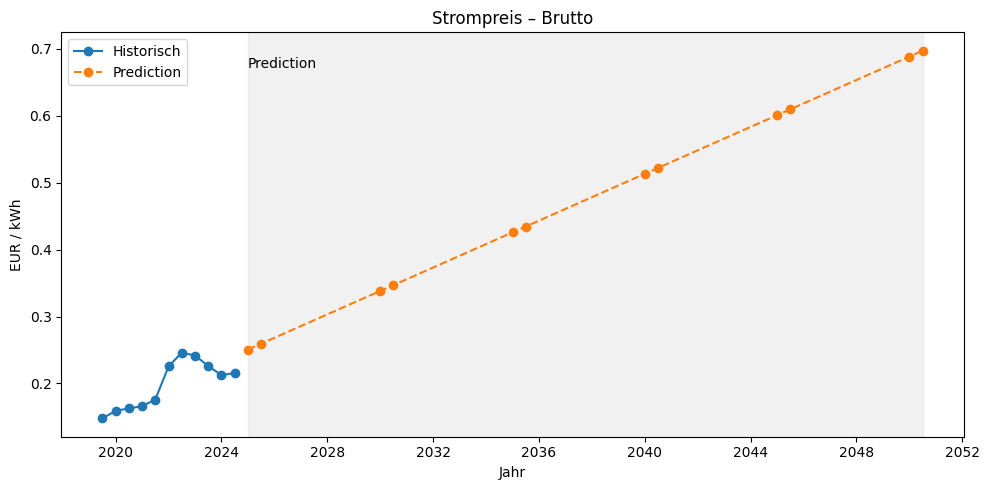

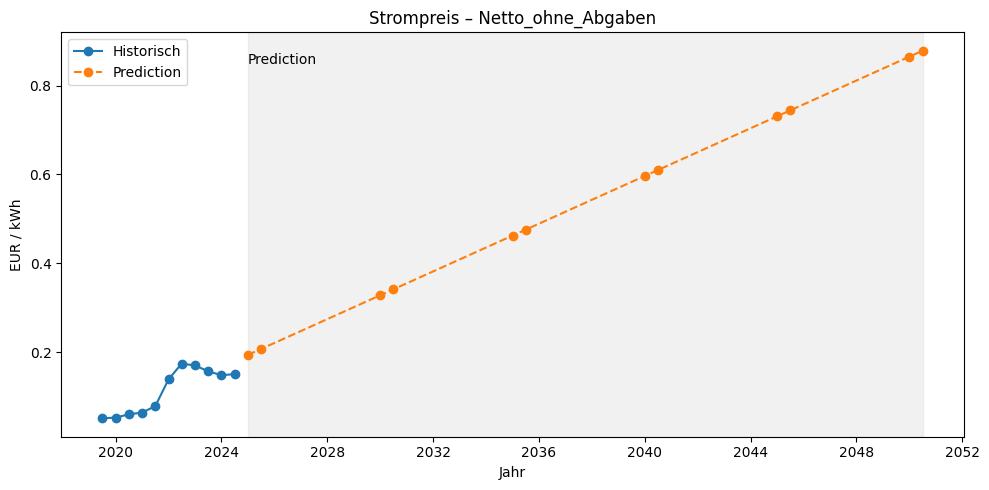

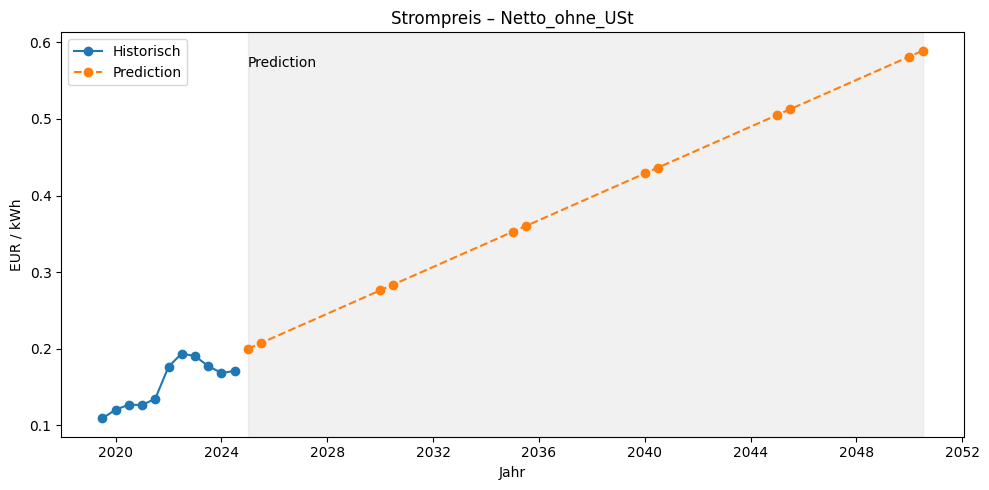

In [160]:


# Zeichnen pro Preisart
for preisart in df_prices_combined["Preisart"].unique():
    df_sub = df_prices_combined[df_prices_combined["Preisart"] == preisart]

    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Historisch
    df_hist = df_sub[df_sub["Type"] == "Historical"]
    ax.plot(df_hist["ds"], df_hist["Preis_EUR_kWh"], label="Historisch", marker="o", color="#1f77b4")

    # Plot Prognose
    df_prog = df_sub[df_sub["Type"] == "Predicted"]
    ax.plot(df_prog["ds"], df_prog["Preis_EUR_kWh"], label="Prediction", linestyle="--", marker="o", color="#ff7f0e")

    # Hintergrund ab 2025 schattieren
    ax.axvspan(pd.to_datetime("2025-01-01"), df_sub["ds"].max(), color="lightgray", alpha=0.3)
    ax.text(pd.to_datetime("2025-01-01"), ax.get_ylim()[1]*0.95, "Prediction", verticalalignment="top")

    ax.set_title(f"Strompreis – {preisart}")
    ax.set_ylabel("EUR / kWh")
    ax.set_xlabel("Jahr")
    ax.legend()
    plt.tight_layout()

    # Speichern
    filename = f"{preisart.replace(' ', '_')}_halbjahr.png"
    fig.savefig(os.path.join(PLOT_OUT_DIR, filename), dpi=300)
    fig.show()
    # plt.close(fig)
